In [1]:
### SETUP ###
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation

### SET DISPLAY PARAMETERS FOR DATAFRAMES AND PLOTS ###
pd.set_option('display.max_rows', None)
plt.rcParams['figure.figsize'] = [5, 5]
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "Helvetica Neue"

# 2 variables
# Phenotype: Normal, Early Death, Bloated
# Alleles: WT, In-frame, frameshift

In [2]:
### READ IN METADATA LABELING INDIVIDUAL SAMPLES ###
# Must be .csv
# Must have a column "Sample Name" with sample names
# Must have a column "Phenotype" (TODO: change to generic label)

metadata_csv = "genopy_lox5/data_lox5/batchAC_phenotype_metadata.csv"
batch_0AC_phenotype_metadata = pd.read_csv(metadata_csv)
batch_0AC_phenotype_metadata

,Sample Name,Phenotype
0,A1,Normal
1,A2,Normal
2,A3,Bloated
3,A4,Normal
4,A5,Bloated
5,A6,Normal
6,A7,Bloated
7,A8,Bloated
8,A9,Normal
9,A10,Bloated


In [3]:
### READ IN ALL DATA ###
# For Batches A/B/C
exported_data_1 = pd.read_csv("genopy_lox5/data_lox5/lox5_Genotyping_Batches_ABCUninj_021820_2020-02-25_18558_Samples_All.csv")
exported_data_2 = pd.read_csv("genopy_lox5/data_lox5/Lox5T3 genotyping experiment sets A_Samples_1-50.csv")
exported_data_3 = pd.read_csv("genopy_lox5/data_lox5/Lox5T3 genotyping experiment sets A_Samples_51-79.csv")
all_data_123 = pd.concat([exported_data_1, exported_data_2, exported_data_3])
# Insert column with sample name for Batches A/B/C
all_data_123.insert(0, "Sample Name", all_data_123["Sample Filename"].apply(lambda filename : filename.split("-")[1].split("_")[0]))
# SPECIFIC TO THIS NOTEBOOK: Remove Batch B from consideration
all_data_123 = all_data_123[["B" not in sample_name for sample_name in list(all_data_123["Sample Name"])]]


# For Batches WT/NONE/MED/SEV
all_data_wnms = pd.read_csv("genopy_lox5/data_lox5/lox5 Genotyping Analysis 090619_2020-02-28_152143_All_Samples.csv")
# Insert column with sample name for Batches WT/NONE/MED/SEV
all_data_wnms.insert(0, "Sample Name", all_data_wnms["Sample Filename"]) 

In [4]:
### MERGE (CONCATENATE) ALL DATA ###
all_exported_data = pd.concat([all_data_123, all_data_wnms])

### FILTER FOR DESIRED PEAKS ###
# Selects only the BLUE dye color peaks
all_exported_data = all_exported_data[all_exported_data["Dye Color"] == "BLUE"]

In [5]:
### ADD COLUMN WITH ROUNDED PEAK SIZE ###
# Rounds the "Size" values and adds new column; removes "*" in front of "size standard" peak lengths
def round_and_convert(size):
    if "*" in size:
        size = size[1:]
    return round(float(size))


all_exported_data.insert(1, "Rounded Peak Size (bp)", all_exported_data["Size"].apply(round_and_convert))

In [6]:
#Isolate peaks given set constraints on minimum peak height and minimum bp
min_bp = 50
min_height = 750

all_exported_data = all_exported_data[all_exported_data["Rounded Peak Size (bp)"] >= min_bp]
all_exported_data = all_exported_data[all_exported_data["Height"] >= min_height]

# COMMENTED OUT IN THIS NOTEBOOK
#wt_peak_bp_1 = 296
#wt_peak_bp_2 = 297

#all_exported_data.insert(2, "WT Peak (T/F)", all_exported_data["Rounded Peak Size (bp)"].apply(lambda size : size in (wt_peak_bp_1, wt_peak_bp_2)))

#spurious_peaks = all_exported_data
#spurious_peaks.insert(0, "Spurious Peak", spurious_peaks["Rounded Peak Size (bp)"].apply(lambda size : size in (185, 223, 245, 246, 247)))
#spurious_peaks.insert(0, "Spurious Peak", spurious_peaks["Rounded Peak Size (bp)"].apply(lambda size : size in (185, 223, 245, 246, 247)))

#TODO: Cleanup for succintness
#REMOVE SPURIOUS PEAKS (BP DETERMINED BY MANUAL REVIEW)
all_exported_data = all_exported_data[all_exported_data["Rounded Peak Size (bp)"] != 195]
all_exported_data = all_exported_data[all_exported_data["Rounded Peak Size (bp)"] != 223]
all_exported_data = all_exported_data[all_exported_data["Rounded Peak Size (bp)"] != 245]
all_exported_data = all_exported_data[all_exported_data["Rounded Peak Size (bp)"] != 246]
all_exported_data = all_exported_data[all_exported_data["Rounded Peak Size (bp)"] != 247]
all_exported_data

,Sample Name,Rounded Peak Size (bp),Sample Filename,Dye Color,"Dye, Sample Peak",Size,Height,Area (Data Point),Area (Base Pairs),Data Point,Begin Point (Data Point),End Point (Data Point),Begin Point (Base Pairs),End Point (Base Pairs),Unnamed: 12
1,C1,292,01-C1_A01_015.fsa,BLUE,"B, 81",291.82,916.0,6509.0,480.10,4520.0,4512.0,4525.0,291.23,292.19,NaN
9,C1,297,01-C1_A01_015.fsa,BLUE,"B, 84",296.98,4751.0,31321.0,2306.25,4590.0,4581.0,4600.0,296.32,297.72,NaN
16,C1,75,01-C1_A01_015.fsa,BLUE,"B, 37",75.12,1677.0,10050.0,851.03,1725.0,1717.0,1736.0,74.44,76.05,NaN
34,C1,78,01-C1_A01_015.fsa,BLUE,"B, 39",77.65,2618.0,16685.0,1404.27,1755.0,1747.0,1761.0,76.98,78.16,NaN
44,C1,303,01-C1_A01_015.fsa,BLUE,"B, 89",303.07,17680.0,125332.0,9186.71,4673.0,4663.0,4693.0,302.34,304.54,NaN
49,C1,302,01-C1_A01_015.fsa,BLUE,"B, 88",301.97,973.0,6746.0,493.34,4658.0,4650.0,4663.0,301.39,302.34,NaN
86,C1,293,01-C1_A01_015.fsa,BLUE,"B, 82",292.86,17988.0,120639.0,8894.66,4534.0,4525.0,4546.0,292.19,293.74,NaN
87,C1,79,01-C1_A01_015.fsa,BLUE,"B, 40",78.74,32445.0,248019.0,20802.52,1768.0,1761.0,1778.0,78.16,79.58,NaN
107,C2,278,02-C2_B01_013.fsa,BLUE,"B, 96",278.05,32594.0,342475.0,25743.51,4294.0,4286.0,4317.0,277.44,279.77,NaN
125,C2,277,02-C2_B01_013.fsa,BLUE,"B, 95",277.14,4725.0,30283.0,2276.45,4282.0,4274.0,4286.0,276.54,277.44,NaN


In [7]:
# CREATE A DATAFRAME OF ALL 0'S FOR APPENDING TO ACTUAL DATA TO ENSURE GROUPY PRESERVES ALL THREE ALLELE TYPES

sample_names = batch_0AC_phenotype_metadata["Sample Name"]
zero_filler_data = pd.DataFrame()

for idx in np.arange(0, 3):
    curr_placeholder_label = ("Wild-type", "Inframe", "Frameshift")[idx]
    curr_placeholder_df = pd.DataFrame(0, index = np.arange(len(sample_names)), columns = all_exported_data.columns)
    curr_placeholder_df["Sample Name"] = sample_names
    curr_placeholder_df["Allele Categorization"] = curr_placeholder_label
    zero_filler_data = pd.concat([zero_filler_data, curr_placeholder_df])
    
zero_filler_data = zero_filler_data.merge(batch_0AC_phenotype_metadata, left_on = "Sample Name", right_on = "Sample Name")
zero_filler_data

,Sample Name,Rounded Peak Size (bp),Sample Filename,Dye Color,"Dye, Sample Peak",Size,Height,Area (Data Point),Area (Base Pairs),Data Point,Begin Point (Data Point),End Point (Data Point),Begin Point (Base Pairs),End Point (Base Pairs),Unnamed: 12,Allele Categorization,Phenotype
0,A1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wild-type,Normal
1,A1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Inframe,Normal
2,A1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Frameshift,Normal
3,A2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wild-type,Normal
4,A2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Inframe,Normal
5,A2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Frameshift,Normal
6,A3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wild-type,Bloated
7,A3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Inframe,Bloated
8,A3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Frameshift,Bloated
9,A4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wild-type,Normal


In [8]:
### LABELS EACH READ WITH CORRESPONDING INDIVIDUAL PHENOTYPE BASED ON METADATA ###
all_exported_data = all_exported_data.merge(batch_0AC_phenotype_metadata, left_on = "Sample Name", right_on = "Sample Name")
all_exported_data

,Sample Name,Rounded Peak Size (bp),Sample Filename,Dye Color,"Dye, Sample Peak",Size,Height,Area (Data Point),Area (Base Pairs),Data Point,Begin Point (Data Point),End Point (Data Point),Begin Point (Base Pairs),End Point (Base Pairs),Unnamed: 12,Phenotype
0,C1,292,01-C1_A01_015.fsa,BLUE,"B, 81",291.82,916.0,6509.0,480.10,4520.0,4512.0,4525.0,291.23,292.19,NaN,Early Death
1,C1,297,01-C1_A01_015.fsa,BLUE,"B, 84",296.98,4751.0,31321.0,2306.25,4590.0,4581.0,4600.0,296.32,297.72,NaN,Early Death
2,C1,75,01-C1_A01_015.fsa,BLUE,"B, 37",75.12,1677.0,10050.0,851.03,1725.0,1717.0,1736.0,74.44,76.05,NaN,Early Death
3,C1,78,01-C1_A01_015.fsa,BLUE,"B, 39",77.65,2618.0,16685.0,1404.27,1755.0,1747.0,1761.0,76.98,78.16,NaN,Early Death
4,C1,303,01-C1_A01_015.fsa,BLUE,"B, 89",303.07,17680.0,125332.0,9186.71,4673.0,4663.0,4693.0,302.34,304.54,NaN,Early Death
5,C1,302,01-C1_A01_015.fsa,BLUE,"B, 88",301.97,973.0,6746.0,493.34,4658.0,4650.0,4663.0,301.39,302.34,NaN,Early Death
6,C1,293,01-C1_A01_015.fsa,BLUE,"B, 82",292.86,17988.0,120639.0,8894.66,4534.0,4525.0,4546.0,292.19,293.74,NaN,Early Death
7,C1,79,01-C1_A01_015.fsa,BLUE,"B, 40",78.74,32445.0,248019.0,20802.52,1768.0,1761.0,1778.0,78.16,79.58,NaN,Early Death
8,C2,278,02-C2_B01_013.fsa,BLUE,"B, 96",278.05,32594.0,342475.0,25743.51,4294.0,4286.0,4317.0,277.44,279.77,NaN,Early Death
9,C2,277,02-C2_B01_013.fsa,BLUE,"B, 95",277.14,4725.0,30283.0,2276.45,4282.0,4274.0,4286.0,276.54,277.44,NaN,Early Death


In [9]:
### LABELS EACH READ AS WT, FRAMESHIFT, OR INFRAME ###
wt_bp = (297, None)
if_bp = np.arange(0, 1000, 3)

def check_allele(size):
    if size in wt_bp:
        return "Wild-type"
    elif size in if_bp:
        return "Inframe"
    else:
        return "Frameshift"
    
all_exported_data.insert(0, "Allele Categorization", all_exported_data["Rounded Peak Size (bp)"].apply(check_allele))
all_exported_data

,Allele Categorization,Sample Name,Rounded Peak Size (bp),Sample Filename,Dye Color,"Dye, Sample Peak",Size,Height,Area (Data Point),Area (Base Pairs),Data Point,Begin Point (Data Point),End Point (Data Point),Begin Point (Base Pairs),End Point (Base Pairs),Unnamed: 12,Phenotype
0,Frameshift,C1,292,01-C1_A01_015.fsa,BLUE,"B, 81",291.82,916.0,6509.0,480.10,4520.0,4512.0,4525.0,291.23,292.19,NaN,Early Death
1,Wild-type,C1,297,01-C1_A01_015.fsa,BLUE,"B, 84",296.98,4751.0,31321.0,2306.25,4590.0,4581.0,4600.0,296.32,297.72,NaN,Early Death
2,Inframe,C1,75,01-C1_A01_015.fsa,BLUE,"B, 37",75.12,1677.0,10050.0,851.03,1725.0,1717.0,1736.0,74.44,76.05,NaN,Early Death
3,Inframe,C1,78,01-C1_A01_015.fsa,BLUE,"B, 39",77.65,2618.0,16685.0,1404.27,1755.0,1747.0,1761.0,76.98,78.16,NaN,Early Death
4,Inframe,C1,303,01-C1_A01_015.fsa,BLUE,"B, 89",303.07,17680.0,125332.0,9186.71,4673.0,4663.0,4693.0,302.34,304.54,NaN,Early Death
5,Frameshift,C1,302,01-C1_A01_015.fsa,BLUE,"B, 88",301.97,973.0,6746.0,493.34,4658.0,4650.0,4663.0,301.39,302.34,NaN,Early Death
6,Frameshift,C1,293,01-C1_A01_015.fsa,BLUE,"B, 82",292.86,17988.0,120639.0,8894.66,4534.0,4525.0,4546.0,292.19,293.74,NaN,Early Death
7,Frameshift,C1,79,01-C1_A01_015.fsa,BLUE,"B, 40",78.74,32445.0,248019.0,20802.52,1768.0,1761.0,1778.0,78.16,79.58,NaN,Early Death
8,Frameshift,C2,278,02-C2_B01_013.fsa,BLUE,"B, 96",278.05,32594.0,342475.0,25743.51,4294.0,4286.0,4317.0,277.44,279.77,NaN,Early Death
9,Frameshift,C2,277,02-C2_B01_013.fsa,BLUE,"B, 95",277.14,4725.0,30283.0,2276.45,4282.0,4274.0,4286.0,276.54,277.44,NaN,Early Death


In [10]:
# CONCATENATE THE FILLER ZERO DF AND ACTUAL DATA DF
all_data_with_zeroes = pd.concat([all_exported_data, zero_filler_data])
all_data_with_zeroes

/Users/David/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,Allele Categorization,Area (Base Pairs),Area (Data Point),Begin Point (Base Pairs),Begin Point (Data Point),Data Point,Dye Color,"Dye, Sample Peak",End Point (Base Pairs),End Point (Data Point),Height,Phenotype,Rounded Peak Size (bp),Sample Filename,Sample Name,Size,Unnamed: 12
0,Frameshift,480.10,6509.0,291.23,4512.0,4520.0,BLUE,"B, 81",292.19,4525.0,916.0,Early Death,292,01-C1_A01_015.fsa,C1,291.82,NaN
1,Wild-type,2306.25,31321.0,296.32,4581.0,4590.0,BLUE,"B, 84",297.72,4600.0,4751.0,Early Death,297,01-C1_A01_015.fsa,C1,296.98,NaN
2,Inframe,851.03,10050.0,74.44,1717.0,1725.0,BLUE,"B, 37",76.05,1736.0,1677.0,Early Death,75,01-C1_A01_015.fsa,C1,75.12,NaN
3,Inframe,1404.27,16685.0,76.98,1747.0,1755.0,BLUE,"B, 39",78.16,1761.0,2618.0,Early Death,78,01-C1_A01_015.fsa,C1,77.65,NaN
4,Inframe,9186.71,125332.0,302.34,4663.0,4673.0,BLUE,"B, 89",304.54,4693.0,17680.0,Early Death,303,01-C1_A01_015.fsa,C1,303.07,NaN
5,Frameshift,493.34,6746.0,301.39,4650.0,4658.0,BLUE,"B, 88",302.34,4663.0,973.0,Early Death,302,01-C1_A01_015.fsa,C1,301.97,NaN
6,Frameshift,8894.66,120639.0,292.19,4525.0,4534.0,BLUE,"B, 82",293.74,4546.0,17988.0,Early Death,293,01-C1_A01_015.fsa,C1,292.86,NaN
7,Frameshift,20802.52,248019.0,78.16,1761.0,1768.0,BLUE,"B, 40",79.58,1778.0,32445.0,Early Death,79,01-C1_A01_015.fsa,C1,78.74,NaN
8,Frameshift,25743.51,342475.0,277.44,4286.0,4294.0,BLUE,"B, 96",279.77,4317.0,32594.0,Early Death,278,02-C2_B01_013.fsa,C2,278.05,NaN
9,Frameshift,2276.45,30283.0,276.54,4274.0,4282.0,BLUE,"B, 95",277.44,4286.0,4725.0,Early Death,277,02-C2_B01_013.fsa,C2,277.14,NaN


In [11]:
all_allele_all_phenotype = all_data_with_zeroes.groupby(["Sample Name", "Phenotype", "Allele Categorization"]).sum()
all_allele_all_phenotype_proportions = all_allele_all_phenotype / (all_allele_all_phenotype.groupby(level = 0).sum())
all_allele_all_phenotype_proportions

Area (Base Pairs)  \
Sample Name                     Phenotype   Allele Categorization                      
01-lox5_INJ_SEV_1_A01_015.fsa   Bloated     Frameshift                      0.926289   
                                            Inframe                         0.018441   
                                            Wild-type                       0.055270   
02-lox5_INJ_SEV_2_B01_013.fsa   Bloated     Frameshift                      0.739771   
                                            Inframe                         0.195165   
                                            Wild-type                       0.065064   
03-lox5_INJ_SEV_3_C01_011.fsa   Bloated     Frameshift                      0.885533   
                                            Inframe                         0.000000   
                                            Wild-type                       0.114467   
04-lox5_INJ_SEV_4_D01_009.fsa   Bloated     Frameshift                      0.720410   
                                            Inframe                         0.211413   
                                            Wild-type                       0.068177   
05-lox5_INJ_SEV_5_E01_007.fsa   Bloated     Frameshift                      0.233431   
                                            Inframe                         0.708426   
                                            Wild-type                       0.058143   
06-lox5_INJ_SEV_6_F01_005.fsa   Bloated     Frameshift                      0.714827   
                                            Inframe                         0.235258   
                                            Wild-type                       0.049916   
07-lox5_INJ_SEV_7_G01_003.fsa   Bloated     Frameshift                      0.926328   
                                            Inframe                         0.000000   
                                            Wild-type                       0.073672   
08-lox5_INJ_MED_8_H01_001.fsa   Normal      Frameshift                      0.504112   
                                            Inframe                         0.255648   
                                            Wild-type                       0.240239   
09-lox5_INJ_MED_9_A02_016.fsa   Normal      Frameshift                      0.475258   
                                            Inframe                         0.417669   
                                            Wild-type                       0.107073   
10-lox5_INJ_MED_10_B02_014.fsa  Normal      Frameshift                      0.399447   
                                            Inframe                         0.505221   
                                            Wild-type                       0.095332   
11-lox5_INJ_MED_11_C02_012.fsa  Normal      Frameshift                      0.921648   
                                            Inframe                         0.009710   
                                            Wild-type                       0.068642   
12-lox5_INJ_NONE_12_D02_010.fsa Normal      Frameshift                      0.842760   
                                            Inframe                         0.000000   
                                            Wild-type                       0.157240   
13-lox5_INJ_NONE_13_E02_008.fsa Normal      Frameshift                      0.403311   
                                            Inframe                         0.544384   
                                            Wild-type                       0.052305   
14-lox5_INJ_NONE_14_F02_006.fsa Normal      Frameshift                      0.269718   
                                            Inframe                         0.660698   
                                            Wild-type                       0.069583   
15-lox5_INJ_NONE_15_G02_004.fsa Normal      Frameshift                      0.044644   
                                            Inframe                         0.857157   
                   

In [12]:
def get_proportions(sample_names, phenotype, allele_categorization):
    # phenotype: list or string
    # allele_categorization: string
    return all_allele_all_phenotype_proportions.loc[pd.IndexSlice[sample_names, phenotype, allele_categorization], ["Area (Base Pairs)"]]["Area (Base Pairs)"]

In [33]:
def box_strip_plot(groups, measure, metadata):
    """
    Displays box plot with superimposed strip plot for specified groups and corresponding specified measure.
    Calculates t-test p-value and titles plot accordingly.
    :param groups: List of strings of names of sample groups to be plotted on x-axis. Must be of length greater than 1.
    :param measure: String of allele type whose proportion is to be plotted on y-axis.
    :param metadata: String of file path of metadata csv with sample names and group identifications.
    :return: none
    """
    if len(groups) <= 1:
        raise ValueError("Must specify more than one group and exactly one measurement.")
        
    sample_metadata = pd.read_csv(metadata).set_index("Sample Name")
    
    #Initialize variable to store DataFrame of all data
    agg_data = pd.DataFrame()
    
    #Iterates through provided group(s) and populates agg_data with each grp_data, where grp_data is df formed from
    #calling get_proportions on names of samples corresponding to group, the group, and the desired allele type
    for grp in groups:
        sample_names = sample_metadata[sample_metadata["Phenotype"] == grp].index
        grp_data = pd.DataFrame({grp : get_proportions(sample_names, grp, measure)})
        if agg_data.empty:
            agg_data = grp_data
        else:
            agg_data = agg_data.merge(grp_data, left_on = "Sample Name", right_on = "Sample Name", how = "outer")
    
    #DEBUG
    print(agg_data)
    print("Number of Samples: " + str(len(agg_data)))
    
    plot = sns.boxplot(data = agg_data, showfliers = False, showmeans = False, meanprops={"marker":"o","markerfacecolor":"red", "markeredgecolor":"black"}, palette = "GnBu")
    plot = sns.swarmplot(data = agg_data, alpha = 0.75, marker = "o", edgecolor = "black", color = "white" , linewidth = 1)
    sns.despine()
    add_stat_annotation(plot, data = agg_data, box_pairs=[("Normal", "Bloated")],
                    test='t-test_ind', text_format='star', loc='inside', verbose=0)

    plt.title("Proportion " + measure + " Alleles for " + "/".join(groups) + " Samples")
    plt.xlabel("Phenotype")
    plt.ylabel("Proportion " + measure + " Alleles")
    
    return None

                                   Normal   Bloated
Sample Name                                        
08-lox5_INJ_MED_8_H01_001.fsa    0.240239       NaN
09-lox5_INJ_MED_9_A02_016.fsa    0.107073       NaN
10-lox5_INJ_MED_10_B02_014.fsa   0.095332       NaN
11-lox5_INJ_MED_11_C02_012.fsa   0.068642       NaN
12-lox5_INJ_NONE_12_D02_010.fsa  0.157240       NaN
13-lox5_INJ_NONE_13_E02_008.fsa  0.052305       NaN
14-lox5_INJ_NONE_14_F02_006.fsa  0.069583       NaN
15-lox5_INJ_NONE_15_G02_004.fsa  0.098199       NaN
A1                               0.145822       NaN
A11                              0.062285       NaN
A14                              0.093910       NaN
A19                              0.058070       NaN
A2                               0.476659       NaN
A20                              0.330288       NaN
A22                              0.450271       NaN
A25                              0.105392       NaN
A27                              0.064314       NaN
A28         

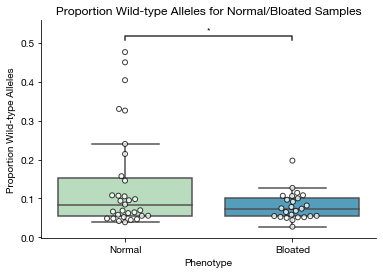

In [34]:
box_strip_plot(["Normal", "Bloated"], "Wild-type", metadata_csv)

                                   Normal   Bloated
Sample Name                                        
08-lox5_INJ_MED_8_H01_001.fsa    0.255648       NaN
09-lox5_INJ_MED_9_A02_016.fsa    0.417669       NaN
10-lox5_INJ_MED_10_B02_014.fsa   0.505221       NaN
11-lox5_INJ_MED_11_C02_012.fsa   0.009710       NaN
12-lox5_INJ_NONE_12_D02_010.fsa  0.000000       NaN
13-lox5_INJ_NONE_13_E02_008.fsa  0.544384       NaN
14-lox5_INJ_NONE_14_F02_006.fsa  0.660698       NaN
15-lox5_INJ_NONE_15_G02_004.fsa  0.857157       NaN
A1                               0.209019       NaN
A11                              0.353187       NaN
A14                              0.405052       NaN
A19                              0.289993       NaN
A2                               0.080797       NaN
A20                              0.000000       NaN
A22                              0.549729       NaN
A25                              0.510985       NaN
A27                              0.872835       NaN
A28         

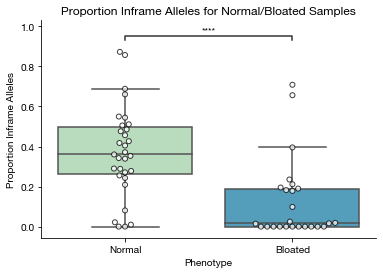

In [35]:
box_strip_plot(["Normal", "Bloated"], "Inframe", metadata_csv)

                                   Normal   Bloated
Sample Name                                        
08-lox5_INJ_MED_8_H01_001.fsa    0.504112       NaN
09-lox5_INJ_MED_9_A02_016.fsa    0.475258       NaN
10-lox5_INJ_MED_10_B02_014.fsa   0.399447       NaN
11-lox5_INJ_MED_11_C02_012.fsa   0.921648       NaN
12-lox5_INJ_NONE_12_D02_010.fsa  0.842760       NaN
13-lox5_INJ_NONE_13_E02_008.fsa  0.403311       NaN
14-lox5_INJ_NONE_14_F02_006.fsa  0.269718       NaN
15-lox5_INJ_NONE_15_G02_004.fsa  0.044644       NaN
A1                               0.645159       NaN
A11                              0.584528       NaN
A14                              0.501038       NaN
A19                              0.651937       NaN
A2                               0.442544       NaN
A20                              0.669712       NaN
A22                              0.000000       NaN
A25                              0.383622       NaN
A27                              0.062851       NaN
A28         

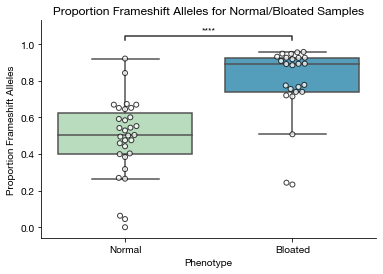

In [36]:
box_strip_plot(["Normal", "Bloated"], "Frameshift", metadata_csv)

In [17]:
sample_metadata = pd.read_csv(metadata_csv).set_index("Sample Name")

normal_sample_names = sample_metadata[sample_metadata["Phenotype"] == "Normal"].index
bloated_sample_names = sample_metadata[sample_metadata["Phenotype"] == "Bloated"].index

In [18]:
def get_aggregate_proportions(sample_names, phenotype, allele_categorization):
    # phenotype: list or string
    # allele_categorization: string
    return all_allele_all_phenotype.loc[pd.IndexSlice[sample_names, phenotype, allele_categorization], ["Area (Base Pairs)"]]["Area (Base Pairs)"]

sum_normal = sum(get_aggregate_proportions(normal_sample_names, "Normal", "Wild-type")) + sum(get_aggregate_proportions(normal_sample_names, "Normal", "Inframe")) +  sum(get_aggregate_proportions(normal_sample_names, "Normal", "Frameshift"))
print("Aggregate proportion normal wild-type: " + str(sum(get_aggregate_proportions(normal_sample_names, "Normal", "Wild-type")) / sum_normal))
print("Aggregate proportion normal inframe: " + str(sum(get_aggregate_proportions(normal_sample_names, "Normal", "Inframe")) / sum_normal))
print("Aggregate proportion normal frameshift: " + str(sum(get_aggregate_proportions(normal_sample_names, "Normal", "Frameshift")) / sum_normal))

sum_normal = sum(get_aggregate_proportions(bloated_sample_names, "Bloated", "Wild-type")) + sum(get_aggregate_proportions(bloated_sample_names, "Bloated", "Inframe")) +  sum(get_aggregate_proportions(bloated_sample_names, "Bloated", "Frameshift"))
print("Aggregate proportion bloated wild-type: " + str(sum(get_aggregate_proportions(bloated_sample_names, "Bloated", "Wild-type")) / sum_normal))
print("Aggregate proportion bloated inframe: " + str(sum(get_aggregate_proportions(bloated_sample_names, "Bloated", "Inframe")) / sum_normal))
print("Aggregate proportion bloated frameshift: " + str(sum(get_aggregate_proportions(bloated_sample_names, "Bloated", "Frameshift")) / sum_normal))

Aggregate proportion normal wild-type: 0.1338542264490654
Aggregate proportion normal inframe: 0.37797523589841775
Aggregate proportion normal frameshift: 0.48817053765251683
Aggregate proportion bloated wild-type: 0.07364366474947674
Aggregate proportion bloated inframe: 0.13941461995299687
Aggregate proportion bloated frameshift: 0.7869417152975263
